# Análise de erro

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import group_delay
from scipy.signal import resample
from commpy.filters import rcosfilter
from commpy.channels import awgn
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

import import_ipynb
from t1_encoding import *
from t2_encoding import *

importing Jupyter notebook from t1_encoding.ipynb
importing Jupyter notebook from t2_encoding.ipynb


[249  72 157   8 195  35  93 254   8 179  88 242]
[121  72 157   8 195  35  93 254   8 179  88 240]


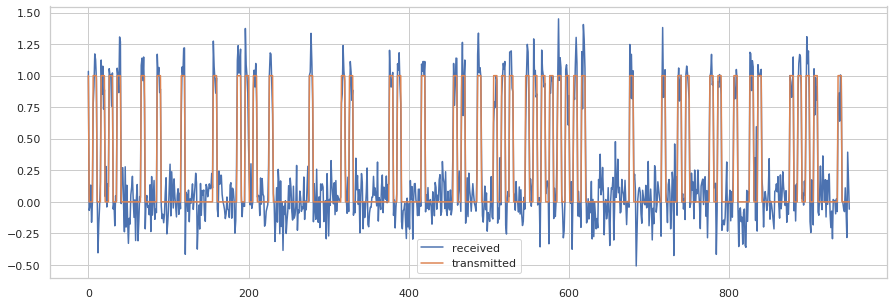

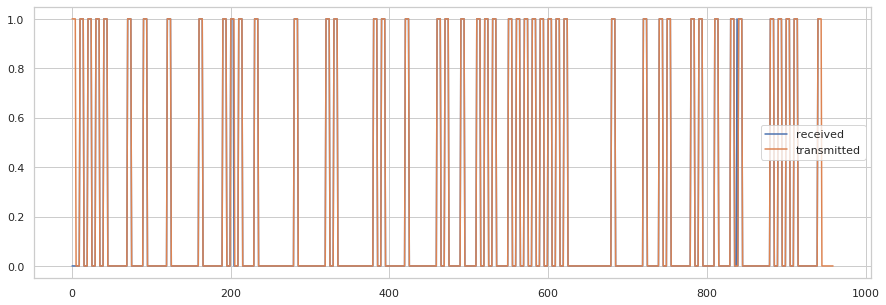

In [15]:
def test(encoding_function, threshold_function, decode_function, frame_size, M, baudrate, snr_db):
    array_size = frame_size // 8
    data = np.random.randint((2**8) - 1, size=array_size, dtype=np.uint8)

    Rb = bitrate(baudrate, M)

    bit_period = 1 / Rb
    sampling_period = bit_period / 10
    sampling_frequency = 1 / sampling_period

    transmitted_encoded_data = encoding_function(data, bit_period, sampling_period)
    transmitted_encoded_data = np.array(transmitted_encoded_data, dtype=np.int8)
    
    N = int(bit_period // sampling_period)
    roll_off = 0.5
    _, rcf = rcosfilter(N=N, 
                        alpha=roll_off, 
                        Ts=bit_period, 
                        Fs=baudrate)
    transmitted_signal = np.convolve(rcf, transmitted_encoded_data, mode='valid')
    
    # channel with white noise
    received_signal = awgn(transmitted_signal, snr_db)

    received_encoded_data = np.convolve(rcf, received_signal, mode='valid')
    received_encoded_data = threshold_function(received_encoded_data)
    
    # Compensate FIR group delay
    grpd = int(np.ceil(np.mean(group_delay((rcf,1), fs=Rb))))
    received_encoded_data = np.roll(received_encoded_data, 2 * grpd, axis=0)
    received_encoded_data[:2 * grpd] = 0
    
    received_decoded_data = decode_function(received_encoded_data, bit_period, sampling_period)
       
    # count symbol and bit error
    size = min(len(received_decoded_data), len(data))
    symbol_count = len(data[:size])
    bit_count = len(np.unpackbits(data[:size]))
    symbol_error_count = np.count_nonzero(abs(data[:size]) 
                                           - received_decoded_data[:size])
    bit_error_count = np.count_nonzero(abs(np.unpackbits(data[:size]) 
                                           - np.unpackbits(received_decoded_data[:size])))
        
#     f, Pxx_den = welch(transmitted_encoded_data, sampling_frequency)
    return {'Rb': Rb,
            'Rs': baudrate,
            'Encoding': str(encoding_function.__name__),
            'M': M,
            'Frame Size': frame_size,
#             'psd': np.array(Pxx_den),
#             'f': np.array(f),
            'snr_db': snr_db,
            'bit_error_count': bit_error_count,
            'symbol_error_count': symbol_error_count,
            'transmitted_encoded_data': transmitted_encoded_data,
            'transmitted_signal': transmitted_signal,
            'received_signal': received_signal,
            'received_encoded_data': received_encoded_data,
            'data': data,
            'received_decoded_data': received_decoded_data,
           }

snr_db = 10 #np.linspace(0, 1000, 100)
test_results = test(encode_unipolar_rz, threshold_unipolar_rz, decode_unipolar_rz, 100, 2, 10, snr_db)
plt.figure(figsize=(15, 5))
plt.plot(test_results['received_signal'], label="received")
plt.plot(test_results['transmitted_signal'], label="transmitted")
plt.legend()
plt.figure(figsize=(15, 5))
plt.plot(test_results['received_encoded_data'], label="received")
plt.plot(test_results['transmitted_encoded_data'], label="transmitted")
plt.legend()

print(test_results['data'])
print(test_results['received_decoded_data'])


In [3]:
if __name__ == '__main__' and callable(globals().get("get_ipython", None)):

    frame_size = 16384
#     baudrates = [1000, 2000, 4000, 8000]
    baudrates = [8000]
    
    encoding_functions = [
        (encode_unipolar_rz, 2),
#         (encode_unipolar_nrz, 2),
#         (encode_bipolar_rz, 2),
#         (encode_bipolar_nrz, 2),
#         (encode_polar4_nrz, 4),
#         (encode_nrzm, 2),
#         (encode_nrzs, 2),
#         (encode_manchester, 2),
    ]
    
    test_results = []

    for baudrate in baudrates:
        for (encoding_function, M) in encoding_functions:
            test_results += [test(encoding_function, frame_size, M, baudrate)]
            

TypeError: test() missing 2 required positional arguments: 'M' and 'baudrate'

In [ ]:
if __name__ == '__main__' and callable(globals().get("get_ipython", None)):

    df = pd.DataFrame(test_results)

    for (encoding, _) in encoding_functions:
        plt.figure(figsize=(15,5))
        plt.title('Densidade de Potência Espectral')
        ax = plt.gca()

        encoding = str(encoding.__name__)

        for baudrate in baudrates:
            label = encoding.replace('encode', '').replace('_', ' ').upper()
            label += ', baudrate = ' + str(baudrate)
            data = df.loc[df['Encoding'] == encoding].loc[df['Rs'] == baudrate].squeeze()
#             plt.plot(data['f'], data['psd'])
            ax = sns.lineplot(data=data,
                              y='psd',
                              x='f',
                              label=label,
                              ax=ax)

        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V²/Hz]')
        plt.legend()
        plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('PSD')
for (encoding, _) in encoding_functions:
    encoding = str(encoding.__name__)
    label = encoding.replace('encode', '').replace('_', ' ').upper()
    label += ', baudrate = ' + str(baudrate)
    df_ = df[df['Encoding'] == encoding]
    plt.plot(df_.iloc[0]['f'], df_.iloc[0]['psd'], label=label)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.legend()